# Loading data

In [133]:
from utils import DataLoader

data_loader = DataLoader('dest_route_pred_sample.csv', delimiter=',')

Loading data... len(vehicle) = 90


In [134]:
# parameters
car_id = 0
seq_len = 10
random_state = 42
test_size = 0.3

In [176]:
# import statements and definitions
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

% matplotlib inline

def visualize_predicted_destination(x, y_true, y_pred):
    path = x.reshape(-1, 2)
    plt.figure()
    plt.scatter(path[:,0], path[:,1], c='b', marker='o') # input seq
    plt.scatter(y_true[0], y_true[1], c='b', marker='x') # true dest
    plt.scatter(y_pred[0], y_pred[1], c='r', marker='x') # pred dest

# Preprocessing data

In [153]:
# get path list
path_instance_list = data_loader.raw_data[car_id]

# filter path shorter than seq_len
path_list = [path.xy for path in path_instance_list if len(path.xy) >= seq_len + 1]
# filter initial points or not
path_list = [path[1:] for path in path_list]

# get input and dest from path
input_list = [path[:seq_len] for path in path_list]
dest_list = [path[-1] for path in path_list]

# data split
x_trn, x_tst, y_trn, y_tst = train_test_split(input_list, dest_list, test_size=0.3, random_state=random_state)

# data scaling
trn_xy_array = np.concatenate(x_trn)
sc = StandardScaler().fit(trn_xy_array)
x_trn = [sc.transform(x) for x in x_trn]
x_tst = [sc.transform(x) for x in x_tst]
y_trn = [sc.transform([y])[0] for y in y_trn]
y_tst = [sc.transform([y])[0] for y in y_tst]

# transform input xy sequence to feature matrix
x_trn = np.concatenate([x.reshape(1, -1) for x in x_trn])
x_tst = np.concatenate([x.reshape(1, -1) for x in x_tst])
# transform dest xy list to output matrix
y_trn, y_tst = np.vstack(y_trn), np.vstack(y_tst)

x_trn.shape, x_tst.shape, y_trn.shape, y_tst.shape

((732, 20), (315, 20), (732, 2), (315, 2))

# Linear Regression (sklearn)

In [167]:
lr = LinearRegression().fit(x_trn, y_trn)
y_hat = lr.predict(x_tst)
mean_squared_error(y_tst, y_hat)

1.1477198408837714

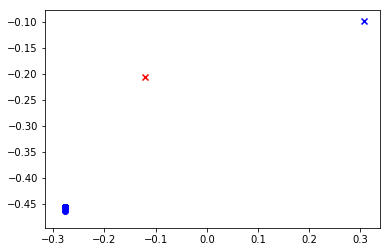

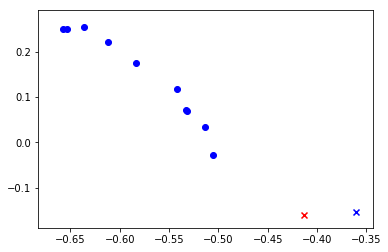

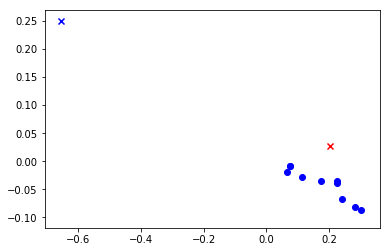

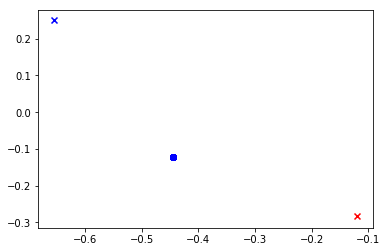

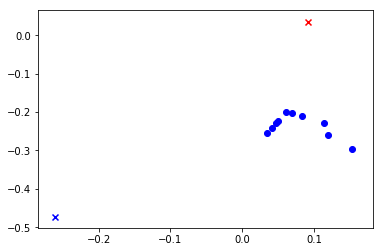

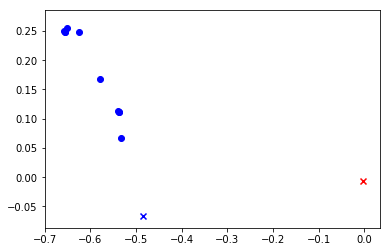

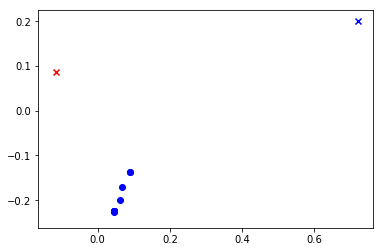

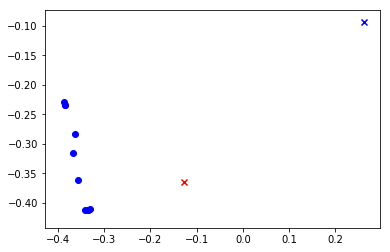

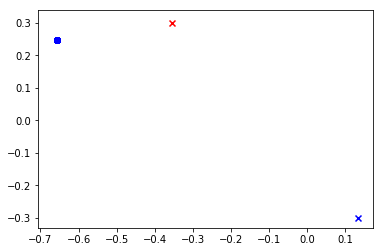

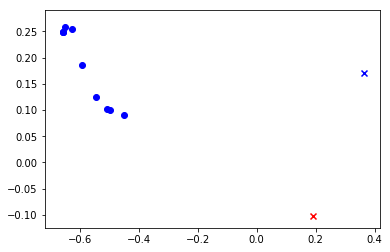

In [177]:
# path_idx = 0
for path_idx in range(10):
    visualize_predicted_destination(x_trn[path_idx], y_trn[path_idx], y_hat[path_idx])

# Tensorflow (linear)

In [193]:
import tensorflow as tf

test mse---> 1.22079


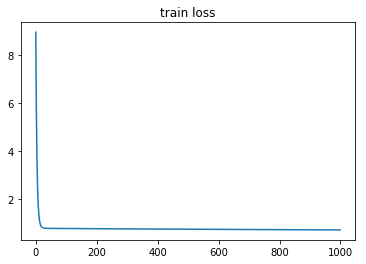

In [191]:
x_input = tf.placeholder(tf.float32, [None, seq_len*2])
y_true = tf.placeholder(tf.float32, [None, 2])

# model 1 (linear)
W = tf.Variable(tf.random_normal([seq_len*2, 2]))
b = tf.Variable(tf.zeros([2]))
y_pred = tf.matmul(x_input, W) + b

mse_loss = tf.losses.mean_squared_error(y_true, y_pred)
train_step = tf.train.GradientDescentOptimizer(0.01).minimize(mse_loss)

cpu_conf = tf.ConfigProto(
    device_count = {'GPU': 0}
)
sess = tf.Session(config=cpu_conf)
tf.global_variables_initializer().run(session=sess)

# Train
trn_loss_list = []
for _ in range(1000):
    _, trn_loss = sess.run([train_step, mse_loss], feed_dict={x_input: x_trn, y_true: y_trn})
    trn_loss_list.append(trn_loss)

plt.plot(range(len(trn_loss_list)), trn_loss_list)
plt.title('train loss')

# Test trained model
tst_loss = sess.run(mse_loss, feed_dict={x_input: x_tst, y_true: y_tst})
print('test mse--->', tst_loss)

# Tensorflow (1 hidden layer)

test mse---> 1.15763


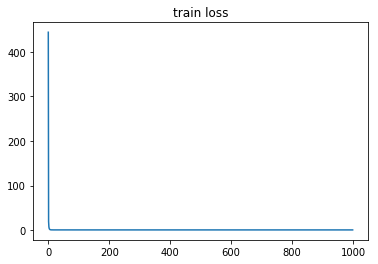

In [199]:
x_input = tf.placeholder(tf.float32, [None, seq_len*2])
y_true = tf.placeholder(tf.float32, [None, 2])

# # model 2 (1 hidden)
n_hidden = 5
W1 = tf.Variable(tf.random_normal([seq_len*2, n_hidden]))
b1 = tf.Variable(tf.zeros([n_hidden]))
h1 = tf.matmul(x_input, W1) + b1
W2 = tf.Variable(tf.random_normal([n_hidden, 2]))
b2 = tf.Variable(tf.zeros([2]))
y_pred = tf.matmul(h1, W2) + b2

mse_loss = tf.losses.mean_squared_error(y_true, y_pred)
train_step = tf.train.GradientDescentOptimizer(0.01).minimize(mse_loss)

cpu_conf = tf.ConfigProto(
    device_count = {'GPU': 0}
)
sess = tf.Session(config=cpu_conf)
tf.global_variables_initializer().run(session=sess)

# Train
trn_loss_list = []
for _ in range(1000):
    _, trn_loss = sess.run([train_step, mse_loss], feed_dict={x_input: x_trn, y_true: y_trn})
    trn_loss_list.append(trn_loss)

plt.plot(range(len(trn_loss_list)), trn_loss_list)
plt.title('train loss')

# Test trained model
tst_loss = sess.run(mse_loss, feed_dict={x_input: x_tst, y_true: y_tst})
print('test mse--->', tst_loss)

# Tensorflow (2 hidden layer)

test mse---> nan


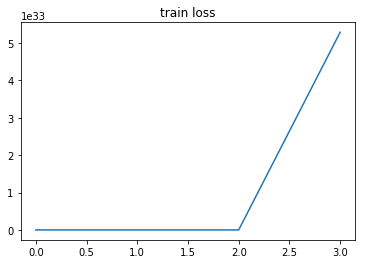

In [202]:
x_input = tf.placeholder(tf.float32, [None, seq_len*2])
y_true = tf.placeholder(tf.float32, [None, 2])

# model 3 (2 hidden)
n_hidden1, n_hidden2 = 5, 3
W1 = tf.Variable(tf.random_normal([seq_len*2, n_hidden1]))
b1 = tf.Variable(tf.zeros([n_hidden1]))
h1 = tf.matmul(x_input, W1) + b1
W2 = tf.Variable(tf.random_normal([n_hidden1, n_hidden2]))
b2 = tf.Variable(tf.zeros([n_hidden2]))
h2 = tf.matmul(h1, W2) + b2
W3 = tf.Variable(tf.random_normal([n_hidden2, 2]))
b3 = tf.Variable(tf.zeros([2]))
y_pred = tf.matmul(h2, W3) + b3

mse_loss = tf.losses.mean_squared_error(y_true, y_pred)
train_step = tf.train.GradientDescentOptimizer(0.01).minimize(mse_loss)

cpu_conf = tf.ConfigProto(
    device_count = {'GPU': 0}
)
sess = tf.Session(config=cpu_conf)
tf.global_variables_initializer().run(session=sess)

# Train
trn_loss_list = []
for _ in range(1000):
    _, trn_loss = sess.run([train_step, mse_loss], feed_dict={x_input: x_trn, y_true: y_trn})
    trn_loss_list.append(trn_loss)

plt.plot(range(len(trn_loss_list)), trn_loss_list)
plt.title('train loss')

# Test trained model
tst_loss = sess.run(mse_loss, feed_dict={x_input: x_tst, y_true: y_tst})
print('test mse--->', tst_loss)